In [904]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.neighbors import LocalOutlierFactor

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import zscore

In [905]:
def sesonal(data, s):
    """
    Функція для візуалізації сезонності в часовому ряді.

    Параметри:
    data (DataFrame або Series): Часовий ряд з датами та значеннями.
    s (int): Період сезонності у часовому ряді.

    Приклад використання:
    sesonal(df, 12)  # Візуалізувати сезонність з періодом 12 (річна сезонність).
    """
    plt.figure(figsize=(19, 8), dpi=80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1, len(data[data.index.year == y]) + 1)), data[data.index.year == y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

def metrics(real, forecast):
    """
    Функція для обчислення різних метрик для оцінки якості прогнозу часового ряду.

    Параметри:
    real (DataFrame, Series або array): Фактичні значення часового ряду.
    forecast (DataFrame, Series або array): Прогнозовані значення часового ряду.

    Приклад використання:
    metrics(real_values, forecast_values)  # Обчислити метрики для оцінки прогнозу.
    """
    
    if type(real) == pd.core.frame.DataFrame:
        real = real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real - forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стаціонарні з ймовірністю {}% відсотків".format(k, v, "не" if v < dftest[0] else "", 100-int(k[:-1])))
    
    forecast = np.array(forecast)
    print('MAD:', round(abs(real - forecast).mean(), 4))
    print('MSE:', round(((real - forecast) ** 2).mean(), 4))
    print('MAPE:', round((abs(real - forecast) / real).mean(), 4))
    print('MPE:', round(((real - forecast) / real).mean(), 4))
    print('Стандартна похибка:', round(((real - forecast) ** 2).mean() ** 0.5, 4))

Аркуш: Econom
Загальні характеристики:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   109 non-null    datetime64[ns]
 1   Price   107 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
None
Статистичні показники:
              Price
count    107.000000
mean   20321.495327
std     5817.362238
min    11400.000000
25%    17000.000000
50%    18000.000000
75%    21050.000000
max    36600.000000
Пропущені значення:
        Month  Price
89 2022-03-01    NaN
90 2022-04-01    NaN
Дублікати:
Empty DataFrame
Columns: [Month, Price]
Index: []
Знайдені викиди:
Empty DataFrame
Columns: [Month, Price]
Index: []


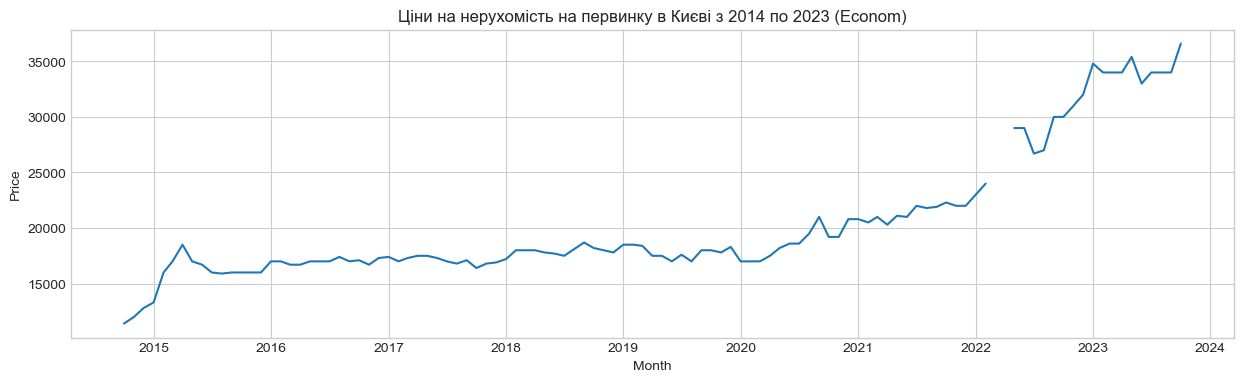

Аркуш: Comfort
Загальні характеристики:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   109 non-null    datetime64[ns]
 1   Price   107 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
None
Статистичні показники:
              Price
count    107.000000
mean   23165.420561
std     6891.368717
min    12200.000000
25%    18950.000000
50%    20600.000000
75%    25500.000000
max    40500.000000
Пропущені значення:
        Month  Price
89 2022-03-01    NaN
90 2022-04-01    NaN
Дублікати:
Empty DataFrame
Columns: [Month, Price]
Index: []
Знайдені викиди:
Empty DataFrame
Columns: [Month, Price]
Index: []


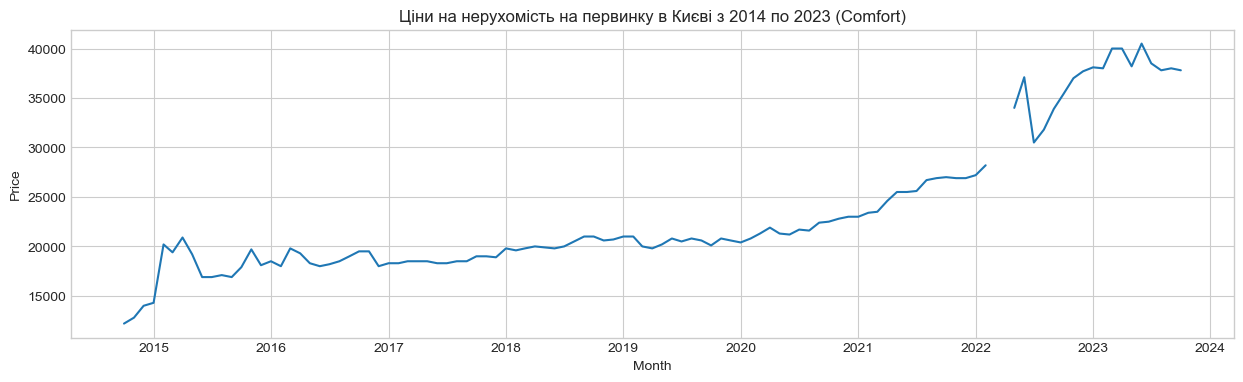

Аркуш: Business
Загальні характеристики:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109 entries, 0 to 108
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Month   109 non-null    datetime64[ns]
 1   Price   107 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.8 KB
None
Статистичні показники:
              Price
count    107.000000
mean   40130.841121
std    14353.853018
min    16900.000000
25%    29750.000000
50%    35200.000000
75%    46250.000000
max    75600.000000
Пропущені значення:
        Month  Price
89 2022-03-01    NaN
90 2022-04-01    NaN
Дублікати:
Empty DataFrame
Columns: [Month, Price]
Index: []
Знайдені викиди:
Empty DataFrame
Columns: [Month, Price]
Index: []


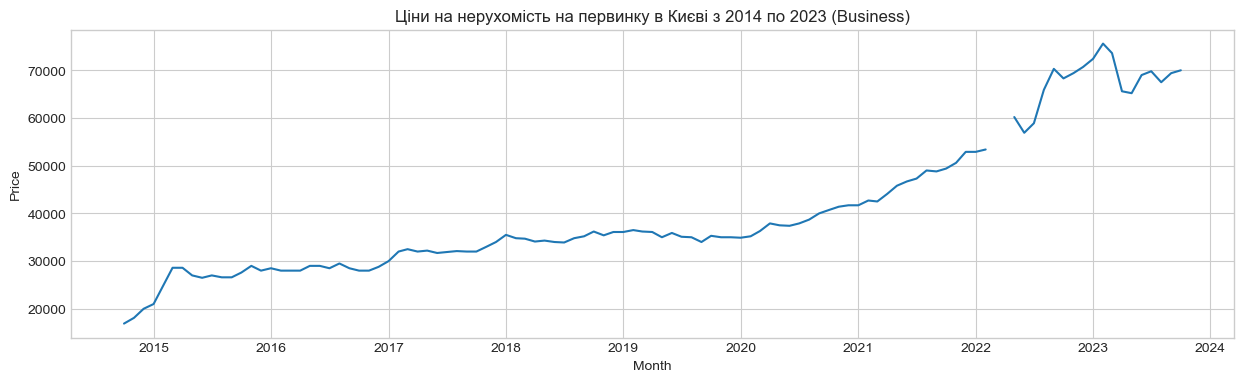

In [906]:
from scipy.stats import zscore

# Функція для завантаження та обробки даних з аркуша
def process_data(file_path, sheet_name):
    # Зчитування даних з аркуша sheet_name файлу Excel
    data = pd.read_excel(file_path, sheet_name=sheet_name)
    # Конвертуємо стовпець 'Month' у формат дати та часу
    data['Month'] = pd.to_datetime(data['Month'])
    
    # Пошук пропущених значень у стовпці 'Price'
    missing_data = data[data['Price'].isnull()]
    
    # Пошук дублікатів в усіх стовпцях
    duplicates = data[data.duplicated()]
    
    # Повертаємо оброблені дані, пропущені значення, дублікати та викиди
    return data, missing_data, duplicates

# Шлях до файлу Excel та список аркушів для обробки
file_path = 'C:\\Users\\Bruger\\Downloads\\Property.xlsx'
sheets = ['Econom', 'Comfort', 'Business']

# Основний цикл для обробки даних з різних аркушів
for sheet_name in sheets:
    # Завантаження та обробка даних для поточного аркуша
    data, missing_data, duplicates = process_data(file_path, sheet_name)
    
    # Виведення загальної інформації про поточний аркуш
    print(f"Аркуш: {sheet_name}")
    print("Загальні характеристики:")
    print(data.info())
    print("Статистичні показники:")
    print(data.describe())
    
    # Виведення пропущених значень та дублікатів
    print("Пропущені значення:")
    print(missing_data)
    print("Дублікати:")
    print(duplicates)
    
    # Обчислення з-оцінок для стовпця 'Price'
    z_scores = zscore(data['Price'])
    
    # Визначення порогу для викидів
    threshold = 3
    
    # Знаходження викидів
    outliers = data[(z_scores > threshold) | (z_scores < -threshold)]
    
    # Виведення викидів
    print("Знайдені викиди:")
    print(outliers)
    
    # Побудова графіку для даних на поточному аркуші
    plt.figure(figsize=(15, 4))
    plt.plot(data['Month'], data['Price'])
    plt.title(f'Ціни на нерухомість на первинку в Києві з 2014 по 2023 ({sheet_name})')
    plt.xlabel('Month')
    plt.ylabel('Price')
    plt.grid(True)
    plt.show()

In [907]:
data_econom = pd.read_excel('C:\\Users\\Bruger\\Downloads\\Property.xlsx', sheet_name = 'Econom')
data_comfort = pd.read_excel('C:\\Users\\Bruger\\Downloads\\Property.xlsx', sheet_name = 'Comfort')
data_business = pd.read_excel('C:\\Users\\Bruger\\Downloads\\Property.xlsx', sheet_name = 'Business')
dataframes = [data_econom, data_comfort, data_business]

for df in dataframes:
    df['Month'] = pd.to_datetime(df['Month'])

In [908]:
data_econom['Price'].interpolate(method='linear', inplace=True)
data_comfort['Price'].interpolate(method='linear', inplace=True)
data_business['Price'].interpolate(method='linear', inplace=True)

In [909]:
print(data_econom.isnull().sum())
print(data_comfort.isnull().sum())
print(data_business.isnull().sum())

Month    0
Price    0
dtype: int64
Month    0
Price    0
dtype: int64
Month    0
Price    0
dtype: int64


In [910]:
# Фільтрація та виведення даних за 2022 рік для кожного об'єкта DataFrame
print("Дані за 2022 рік для об'єкта 'data_econom':")
print(data_econom.loc[data_econom['Month'].dt.year == 2022])
print("Дані за 2022 рік для об'єкта 'data_comfort':")
print(data_comfort.loc[data_comfort['Month'].dt.year == 2022])
print("Дані за 2022 рік для об'єкта 'data_business':")
print(data_business.loc[data_business['Month'].dt.year == 2022])

Дані за 2022 рік для об'єкта 'data_econom':
        Month         Price
87 2022-01-01  23000.000000
88 2022-02-01  24000.000000
89 2022-03-01  25666.666667
90 2022-04-01  27333.333333
91 2022-05-01  29000.000000
92 2022-06-01  29000.000000
93 2022-07-01  26700.000000
94 2022-08-01  27000.000000
95 2022-09-01  30000.000000
96 2022-10-01  30000.000000
97 2022-11-01  31000.000000
98 2022-12-01  32000.000000
Дані за 2022 рік для об'єкта 'data_comfort':
        Month         Price
87 2022-01-01  27200.000000
88 2022-02-01  28200.000000
89 2022-03-01  30133.333333
90 2022-04-01  32066.666667
91 2022-05-01  34000.000000
92 2022-06-01  37100.000000
93 2022-07-01  30500.000000
94 2022-08-01  31800.000000
95 2022-09-01  33900.000000
96 2022-10-01  35400.000000
97 2022-11-01  37000.000000
98 2022-12-01  37700.000000
Дані за 2022 рік для об'єкта 'data_business':
        Month         Price
87 2022-01-01  52900.000000
88 2022-02-01  53400.000000
89 2022-03-01  55666.666667
90 2022-04-01  57933.3333

Text(0.5, 1.0, "Пошук аномалій для категорії 'Econom'")

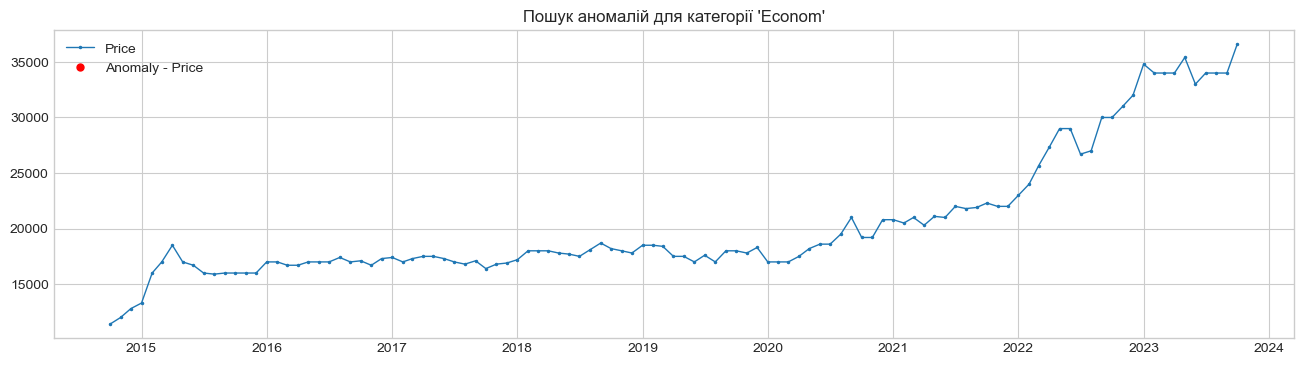

In [911]:
# Встановлення індексу для `data_econom` на основі стовпця 'Month'
data_econom.set_index('Month', inplace=True)

# Створення об'єкта ThresholdAD з вказаними порогами для виявлення аномалій
threshold_ad = ThresholdAD(high=36700, low=11300)

# Знаходження аномалій у часовому ряді за допомогою об'єкта ThresholdAD
anomalies = threshold_ad.detect(data_econom)

# Виведення графіка часового ряду з позначками аномалій
plot(data_econom, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.title("Пошук аномалій для категорії 'Econom'")

In [912]:
anomalies[anomalies.Price]

,Price
Month,


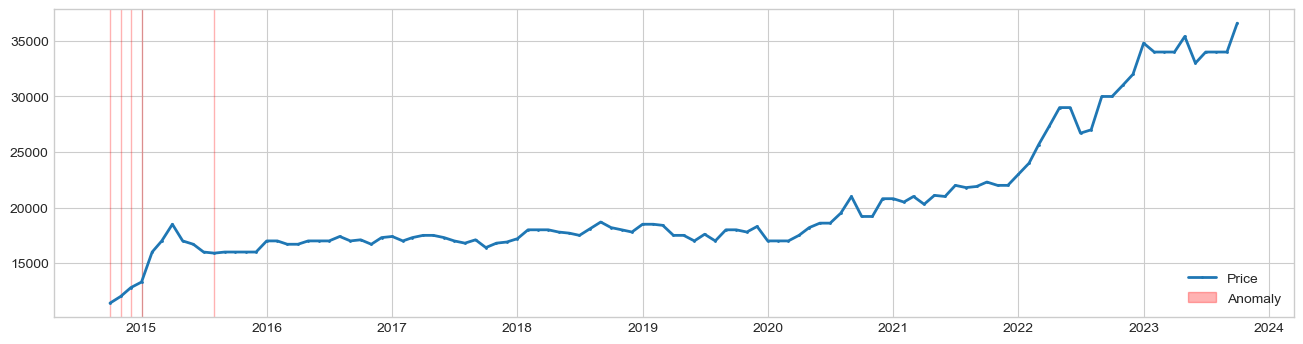

In [913]:
# Створення об'єкту для виявлення викидів з використанням методу LOF
outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.05))

# Виявлення аномалій у часовому ряді "data_econom"
anomalies = outlier_detector.fit_detect(data_econom)

# Візуалізація даних разом із виявленими аномаліями
plot(data_econom, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')

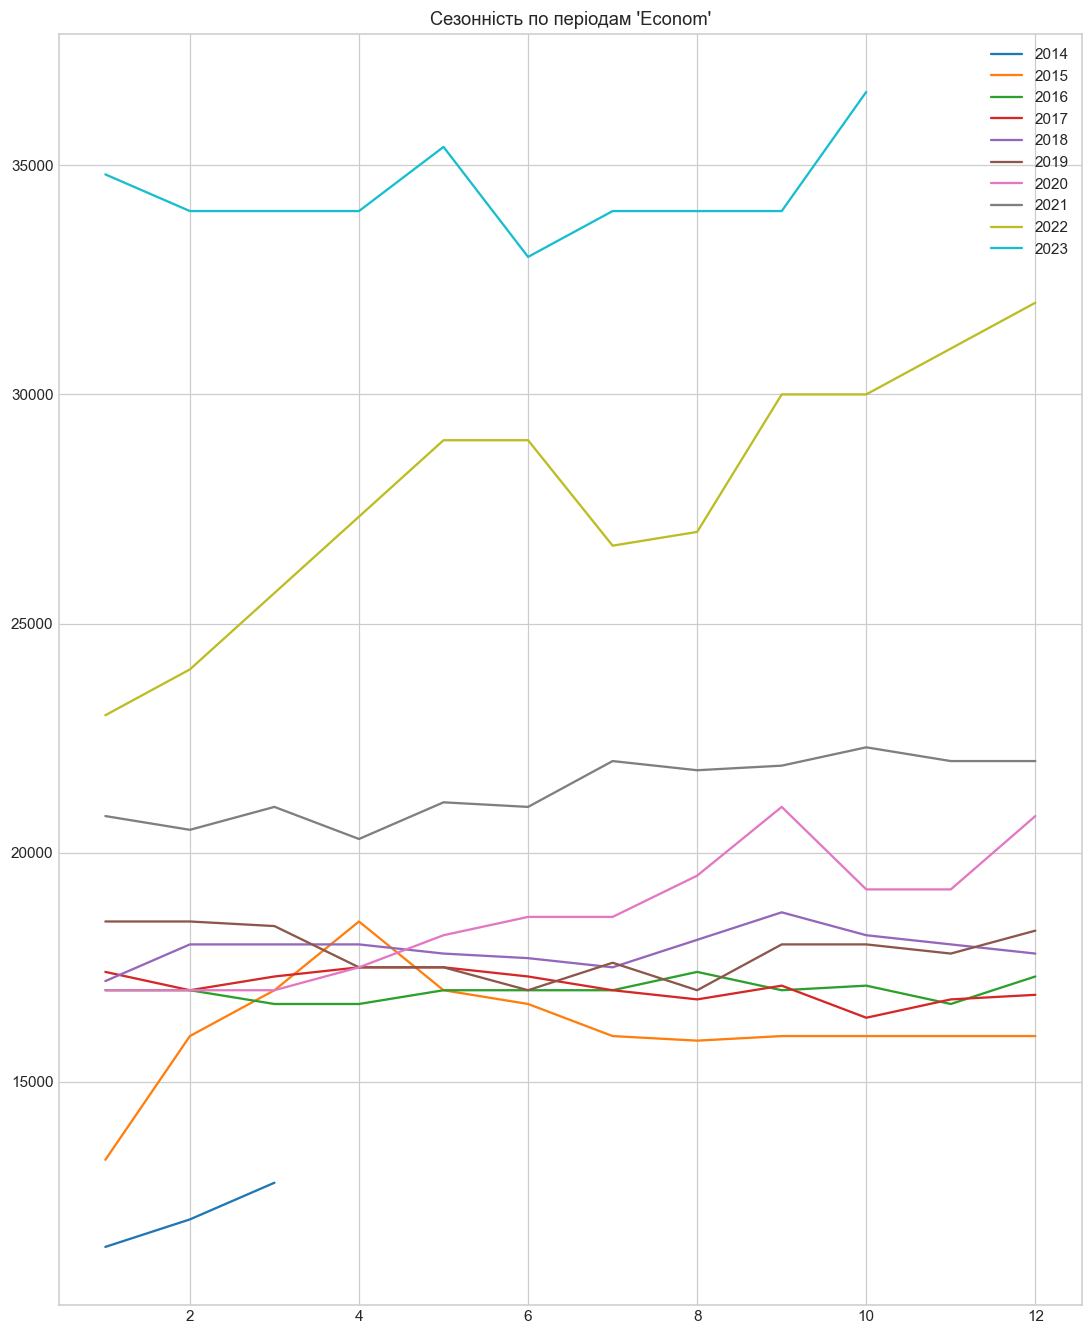

In [914]:
def sesonal(data_econom, s):
    # Створення нового графіка розміром 12x15 та з роздільністю 110 dpi
    plt.figure(figsize=(12, 15), dpi=110)
    
    # Ітерація через унікальні роки в індексі "data_econom"
    for i, y in enumerate(data_econom.index.year.unique()):  
        # Побудова графіку для кожного року
        # Горизонтальна вісь відображає періоди, вертикальна - значення цін
        plt.plot(list(range(1,len(data_econom[data_econom.index.year==y])+1)), data_econom[data_econom.index.year==y][data_econom.columns[0]].values, label=y)
    
    # Додавання заголовку до графіку
    plt.title("Сезонність по періодам 'Econom'")
    
    # Додавання легенди до графіку для ідентифікації років
    plt.legend(loc="best")
    
    # Відображення графіку
    plt.show()

# Виклик функції "sesonal" для аналізу сезонності
sesonal(data_econom, 12)

Text(0.5, 0.98, 'Мультиплікатива модель для Econom')

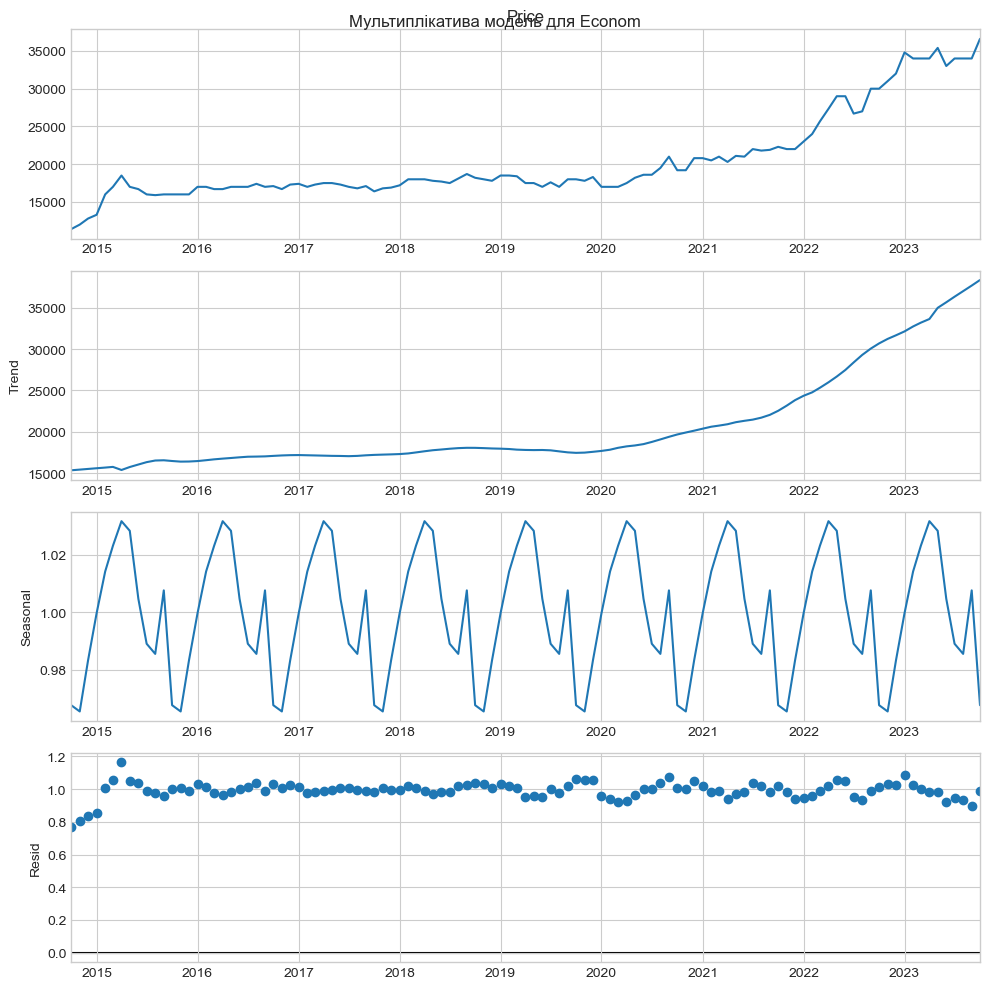

In [915]:
# Використання функції seasonal_decompose для аналізу сезонності у вхідних даних "data_econom.Price"
# Модель "multiplicative" використовується для мультиплікативного розкладу, а "extrapolate_trend=12" дозволяє розширити тренд на 12 періодів
result_M = seasonal_decompose(data_econom.Price, model='multiplicative', extrapolate_trend=12)

# Оновлення параметрів графіку для встановлення розміру фігури 10x10
plt.rcParams.update({'figure.figsize': (10, 10)})

# Побудова графіків результатів аналізу сезонності та встановлення заголовку
result_M.plot().suptitle('Мультиплікативна модель для Econom')

Text(0.5, 0.98, 'Адитивна модель для Econom')

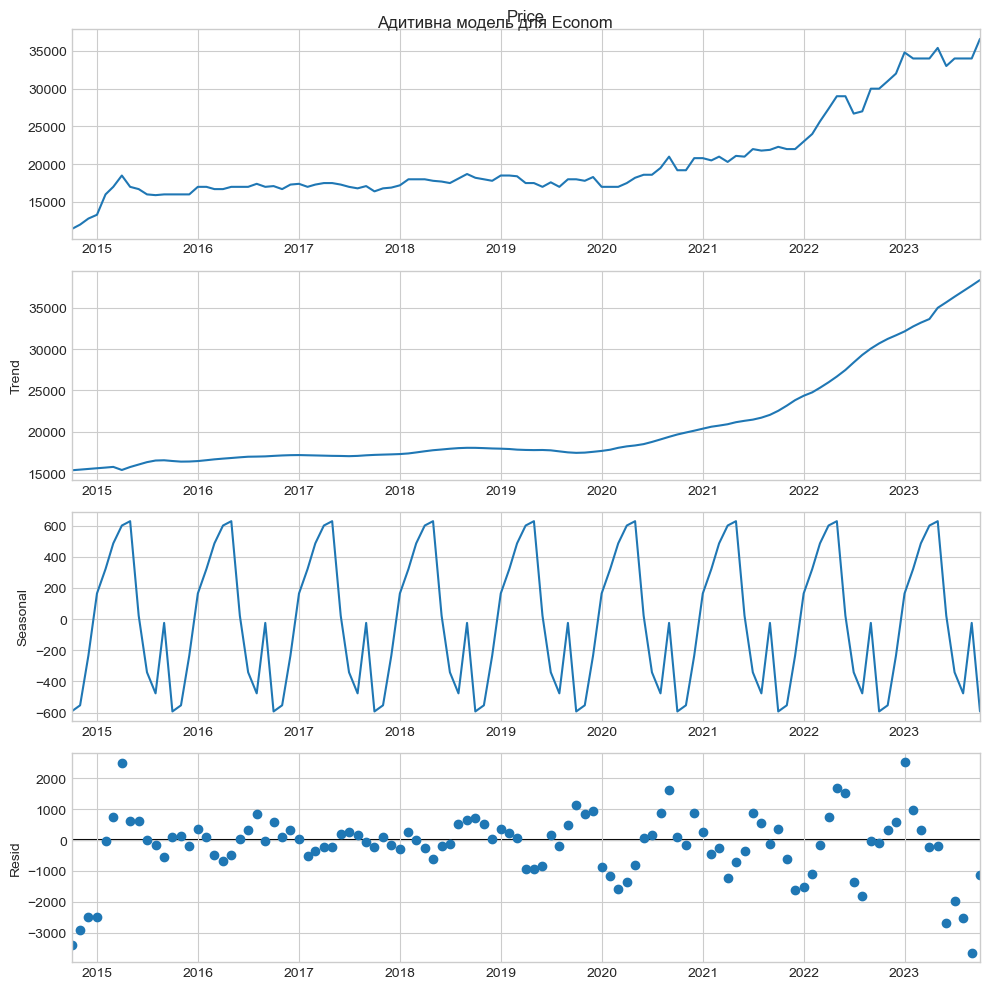

In [916]:
# Використання функції seasonal_decompose для аналізу сезонності у вхідних даних "data_econom.Price"
# Модель "additive" використовується для адитивного розкладу, а "extrapolate_trend=12" дозволяє розширити тренд на 12 періодів
result_M = seasonal_decompose(data_econom.Price, model='additive', extrapolate_trend=12)

# Оновлення параметрів графіку для встановлення розміру фігури 10x10
plt.rcParams.update({'figure.figsize': (10, 10)})

# Побудова графіків результатів аналізу сезонності та встановлення заголовку
result_M.plot().suptitle('Адитивна модель для Econom')

In [917]:
# Продовжуємо виявлення аномалій та декомпозицію даних для аркушів Comfort, Business

Text(0.5, 1.0, "Пошук аномалій для категорії 'Business'")

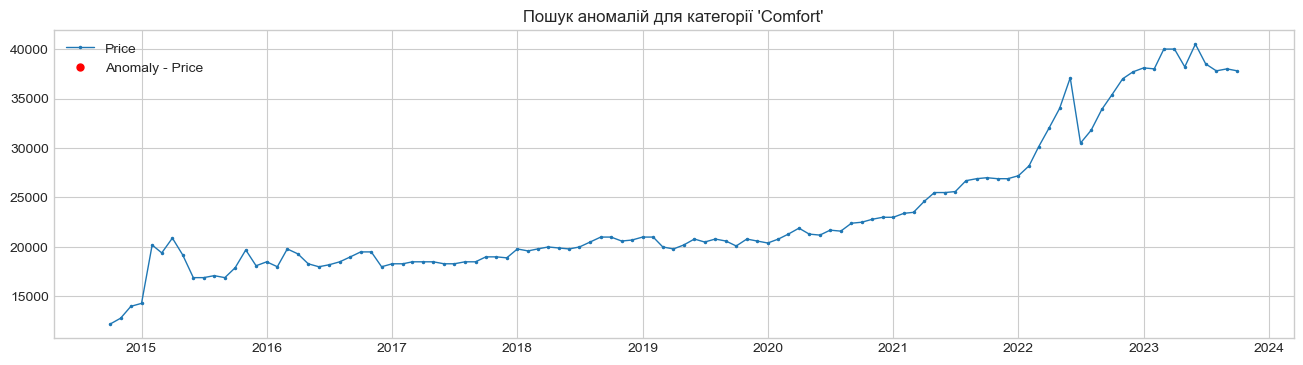

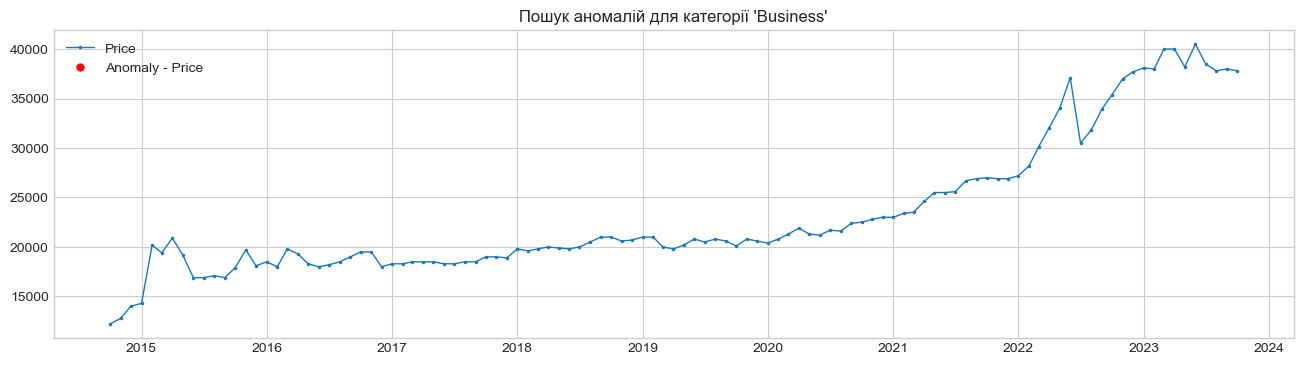

In [918]:
data_comfort.set_index('Month', inplace=True)
threshold_ad = ThresholdAD(high=40500, low=12100)
anomalies = threshold_ad.detect(data_comfort)
plot(data_comfort, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.title("Пошук аномалій для категорії 'Comfort'")

data_business.set_index('Month', inplace=True)
threshold_ad = ThresholdAD(high=75600, low=16900)
anomalies = threshold_ad.detect(data_business)
plot(data_comfort, anomaly=anomalies, ts_linewidth=1, ts_markersize=3, anomaly_markersize=5, anomaly_color='red', anomaly_tag="marker")
plt.title("Пошук аномалій для категорії 'Business'")


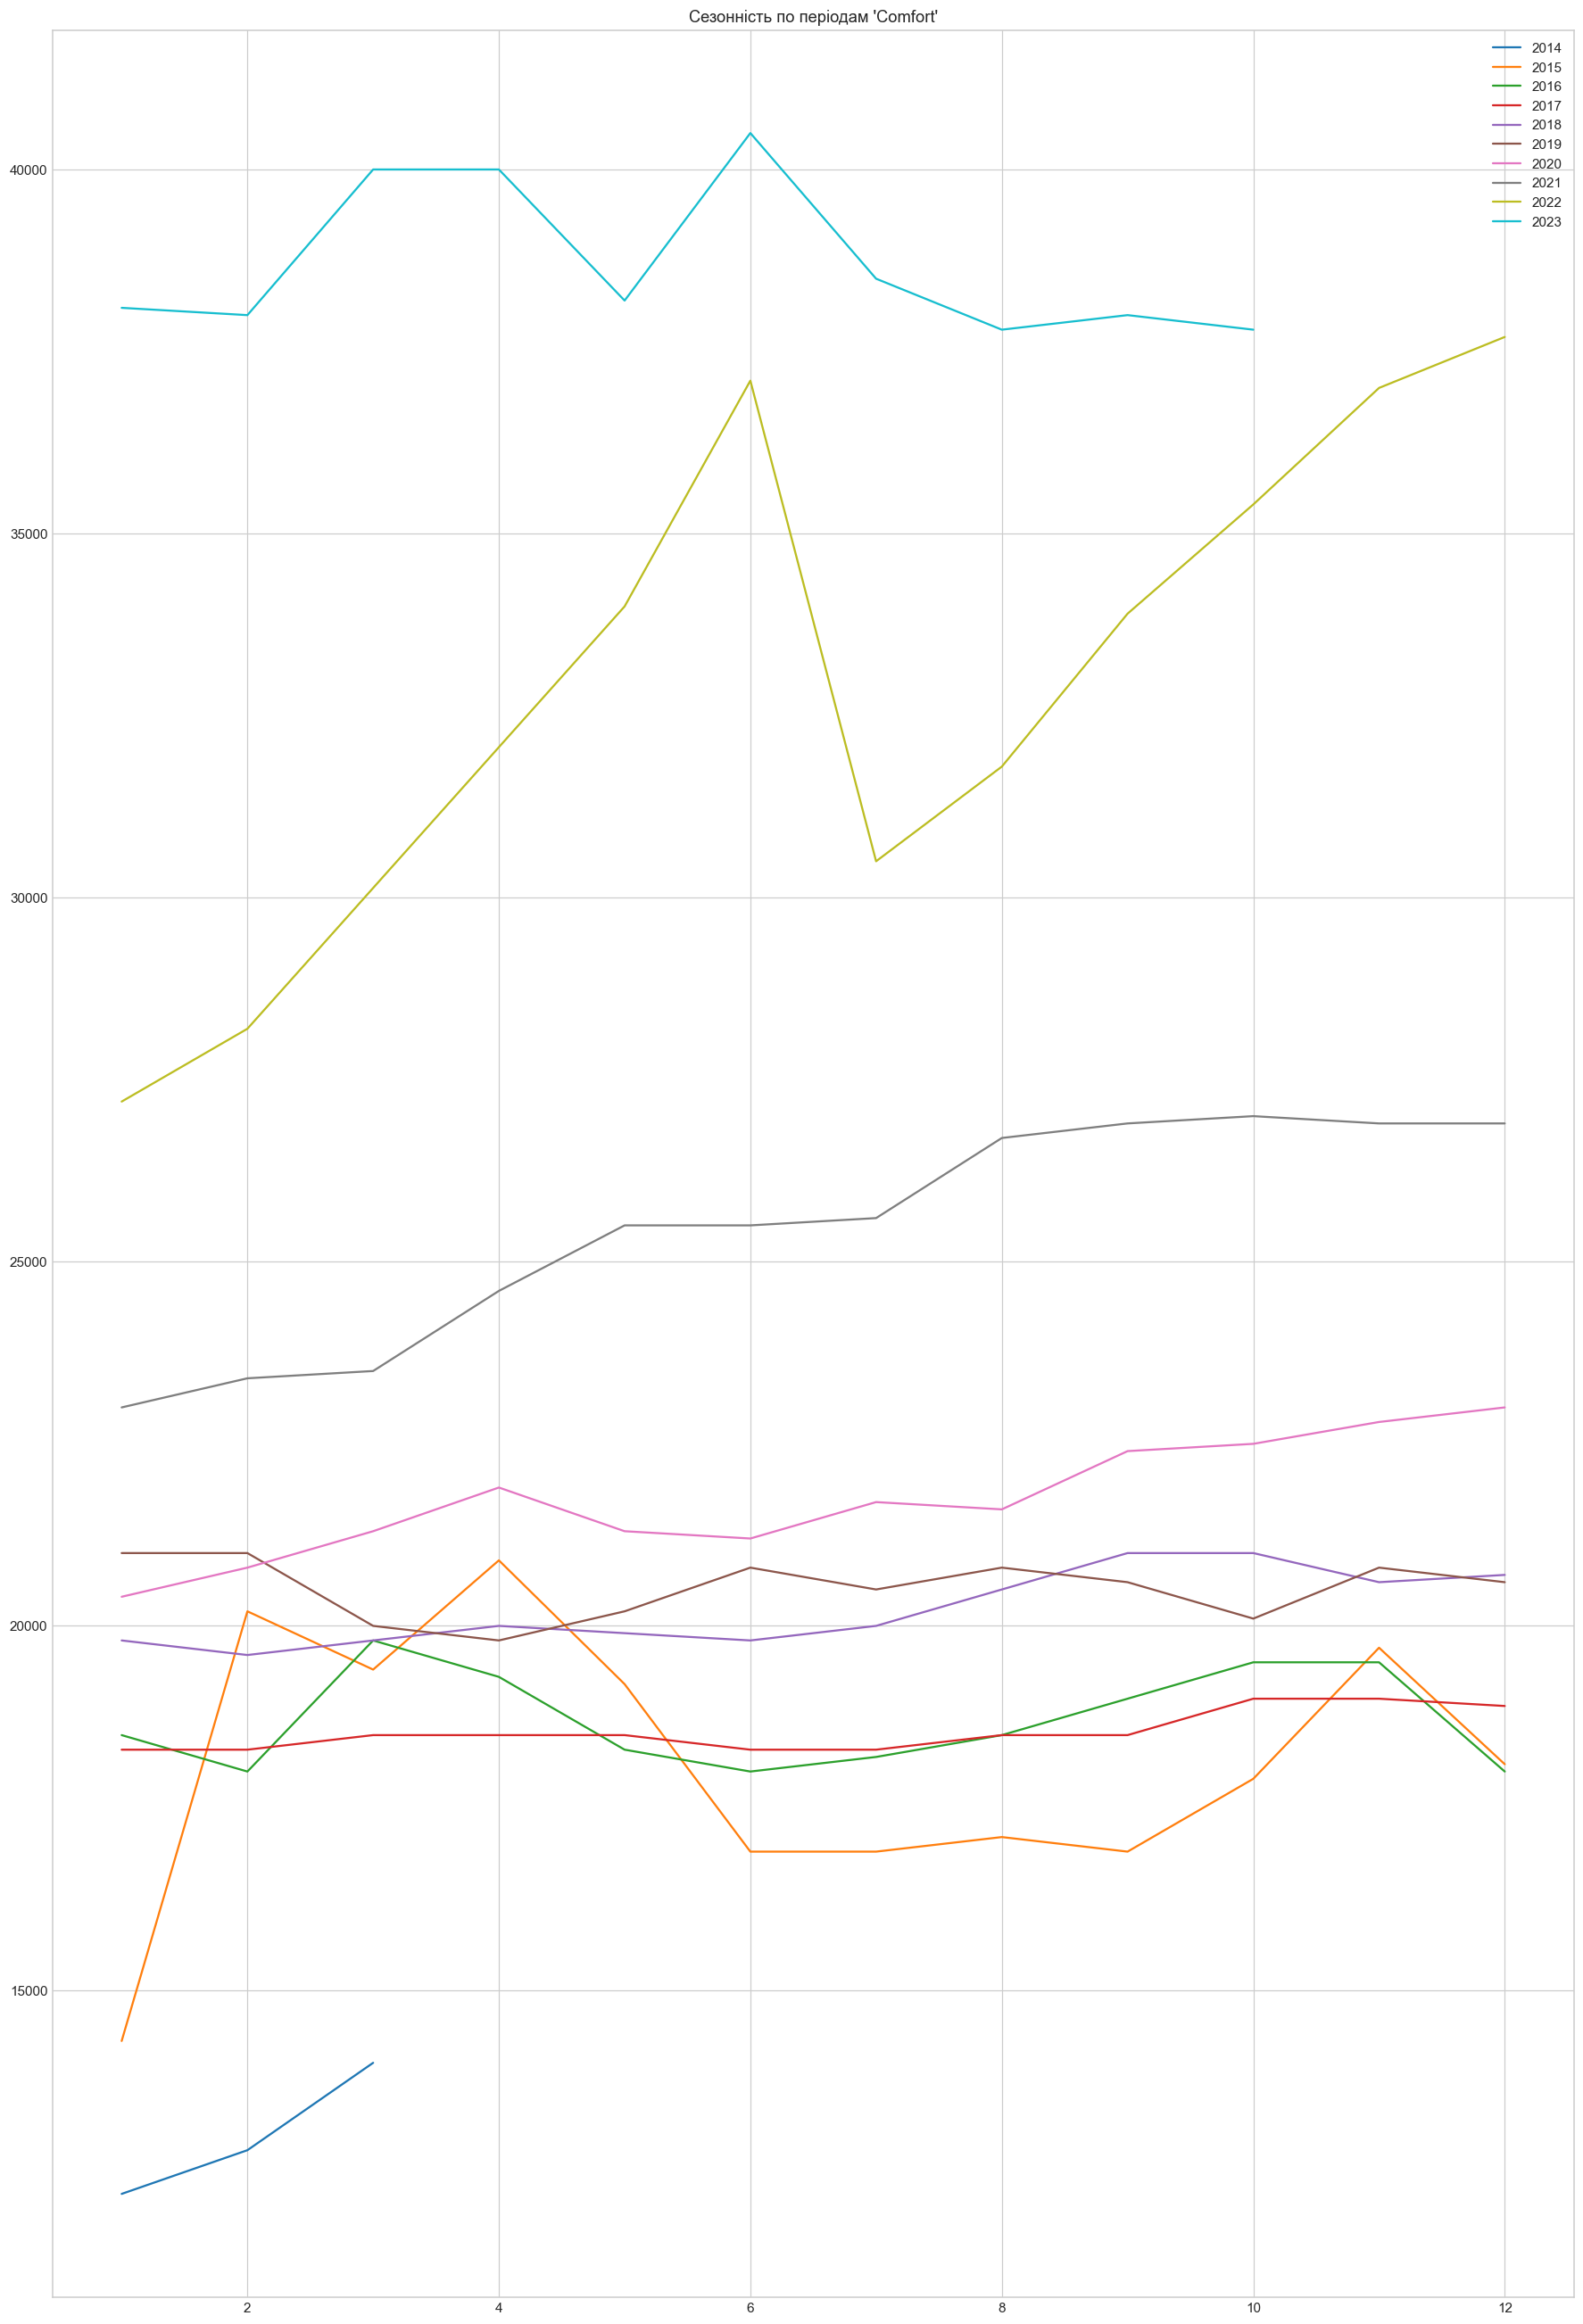

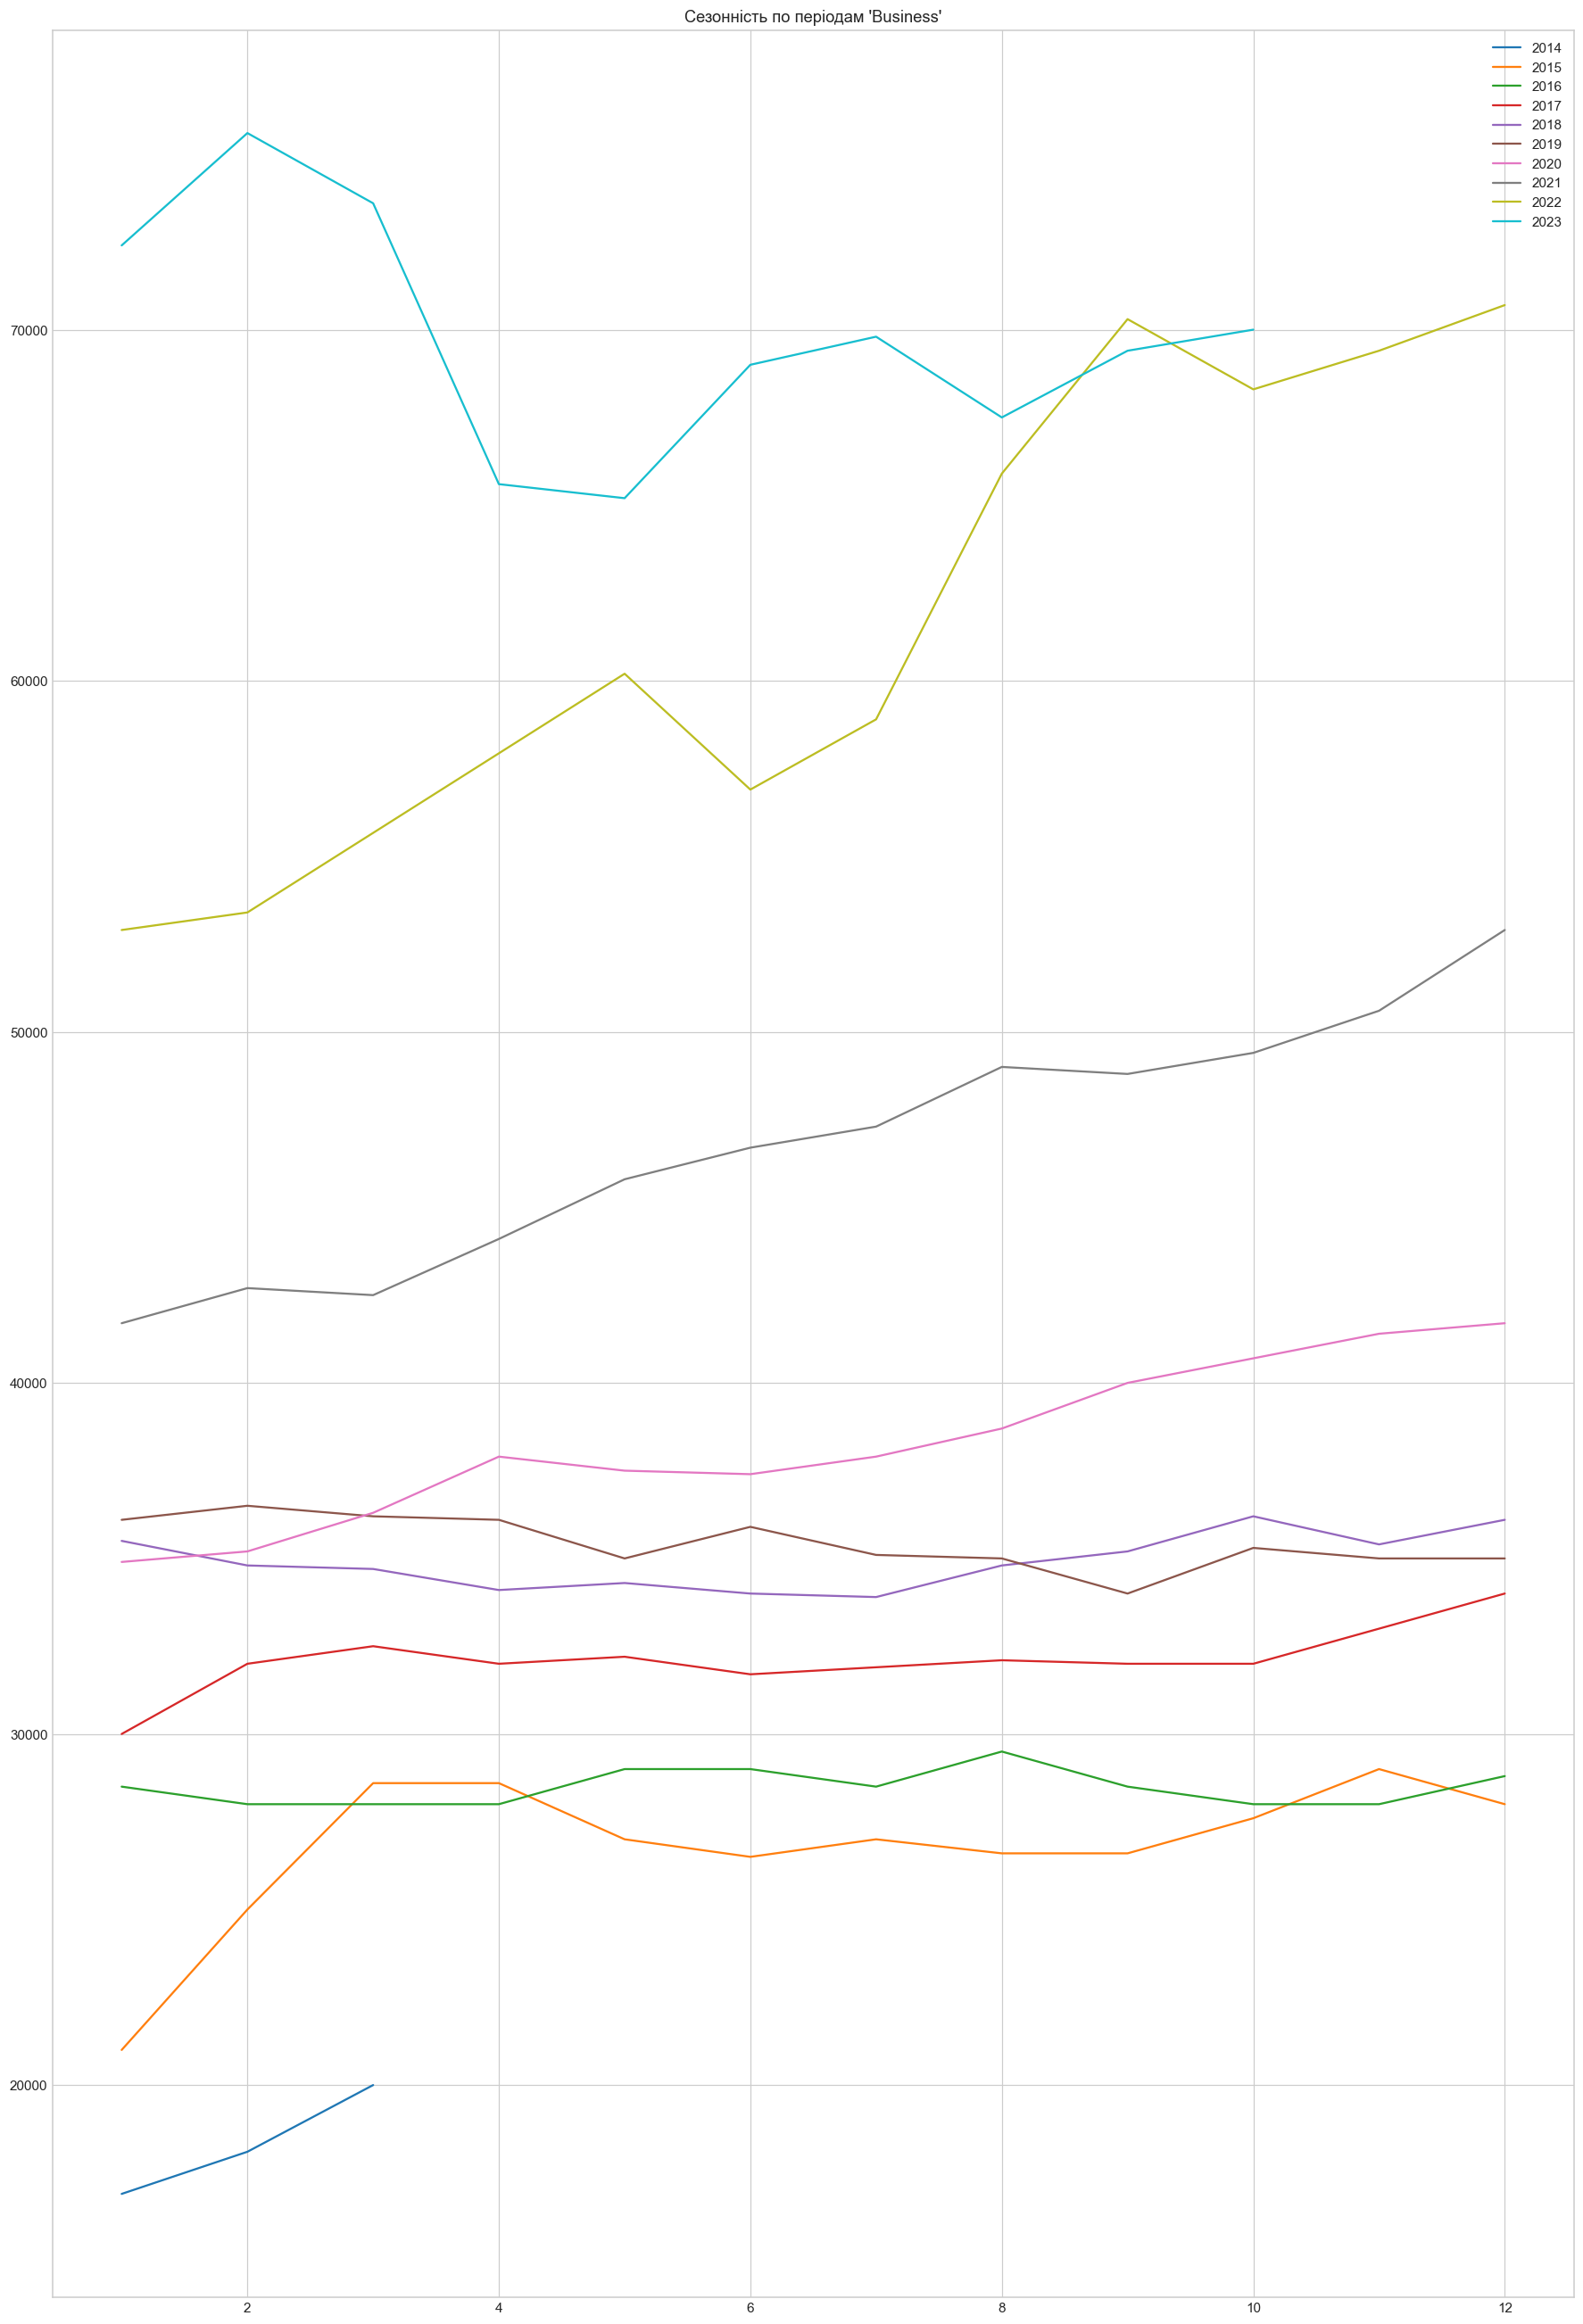

In [919]:
def sesonal(data_comfort, s):
    plt.figure(figsize=(20, 30), dpi=110)
    for i, y in enumerate(data_econom.index.year.unique()):  
        plt.plot(list(range(1,len(data_comfort[data_econom.index.year==y])+1)), data_comfort[data_comfort.index.year==y][data_comfort.columns[0]].values, label=y)
    plt.title("Сезонність по періодам 'Comfort'")
    plt.legend(loc="best")
    plt.show()
sesonal(data_comfort, 12)

def sesonal(data_business, s):
    plt.figure(figsize=(20, 30), dpi=110)
    for i, y in enumerate(data_business.index.year.unique()):  
        plt.plot(list(range(1,len(data_comfort[data_business.index.year==y])+1)), data_business[data_business.index.year==y][data_business.columns[0]].values, label=y)
    plt.title("Сезонність по періодам 'Business'")
    plt.legend(loc="best")
    plt.show()
sesonal(data_business, 12)


Text(0.5, 0.98, 'Мультиплікатива модель для Business')

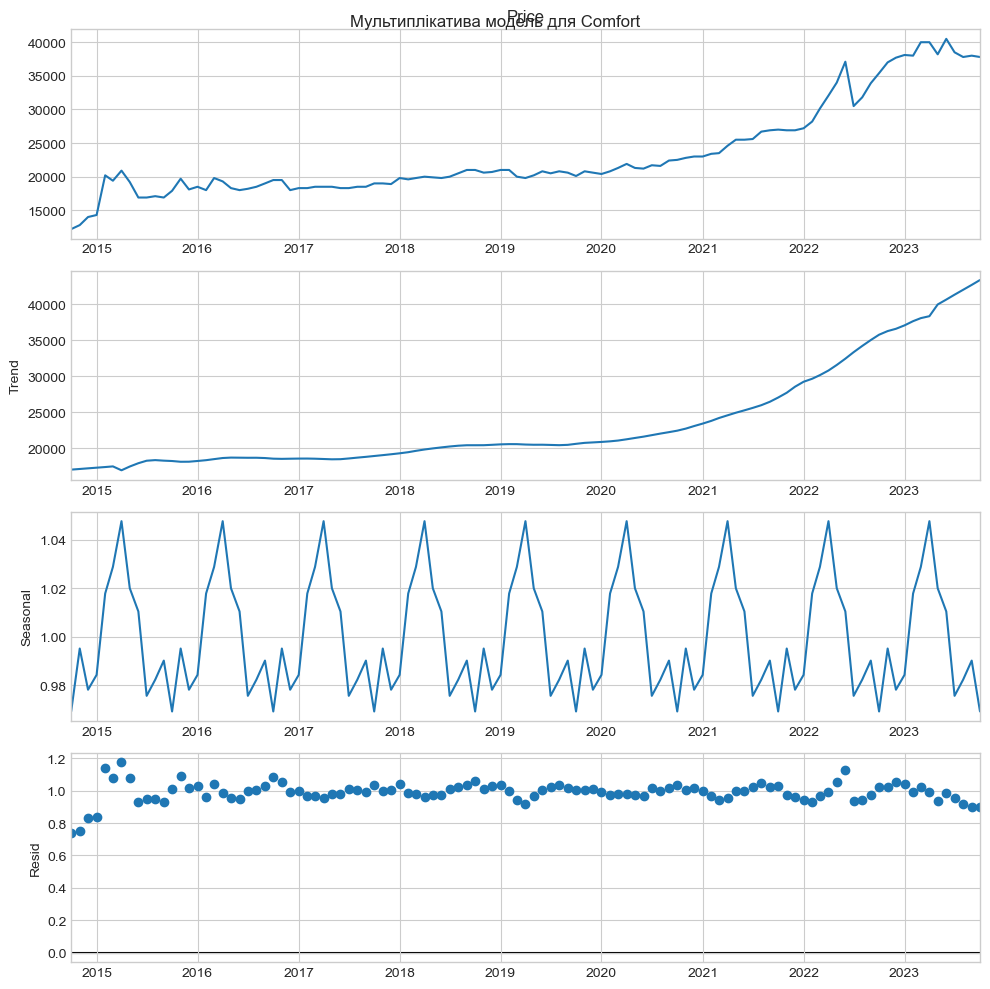

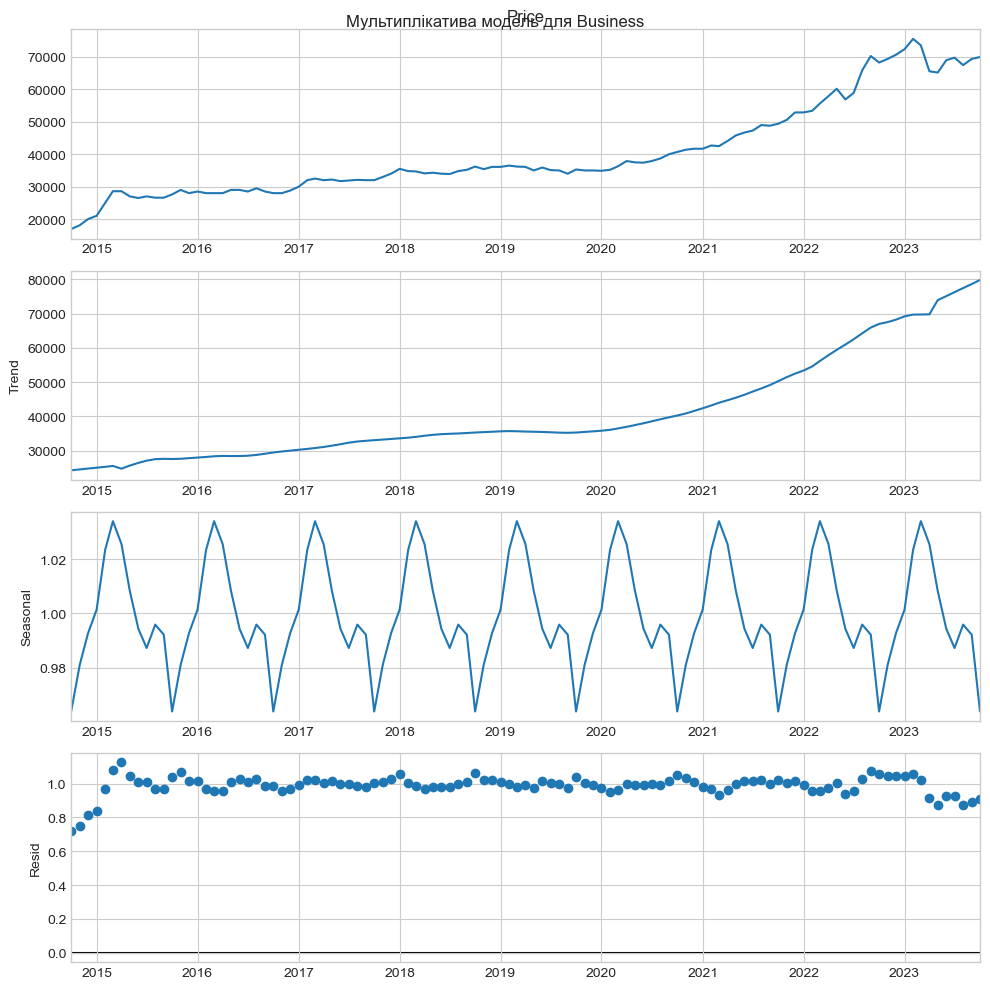

In [920]:
result_M = seasonal_decompose(data_comfort.Price, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель для Comfort')

result_M = seasonal_decompose(data_business.Price, model='multiplicative', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Мультиплікатива модель для Business')

Text(0.5, 0.98, 'Адитивна модель для Business')

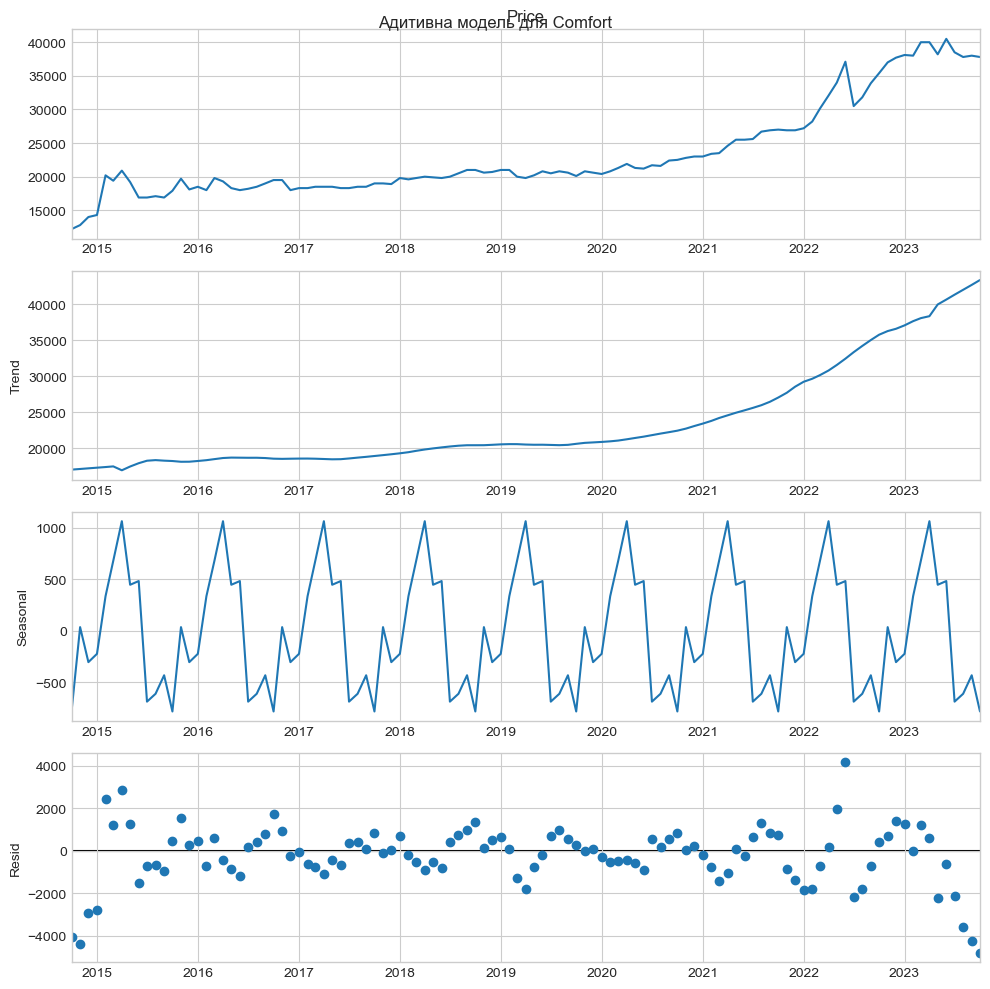

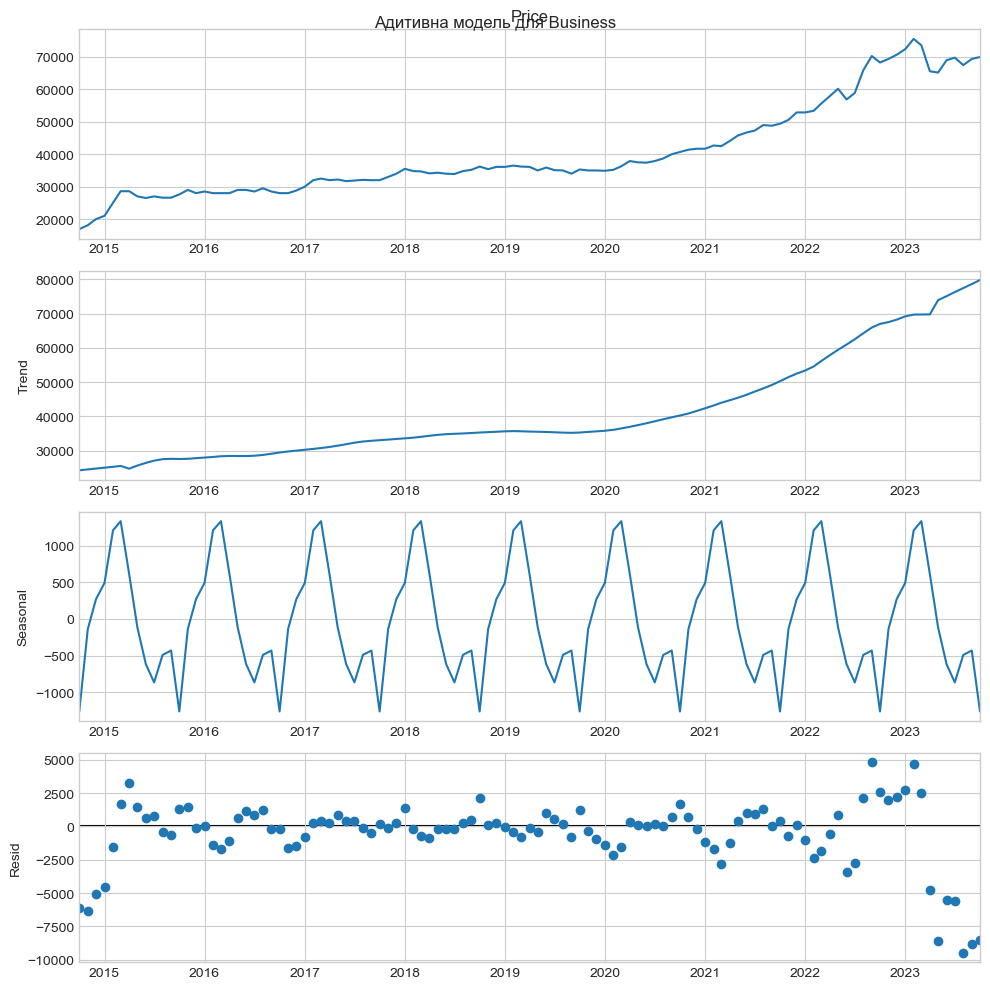

In [921]:
result_M = seasonal_decompose(data_comfort.Price, model='additive', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Адитивна модель для Comfort')


result_M = seasonal_decompose(data_business.Price, model='additive', extrapolate_trend=12)
plt.rcParams.update({'figure.figsize': (10,10)})
result_M.plot().suptitle('Адитивна модель для Business')

In [922]:
# Робимо прогноз для нерухомості Econom
train_econom=data_econom['2014':'2022']
train_econom.head()

,Price
Month,
2014-10-01,11400.0
2014-11-01,12000.0
2014-12-01,12800.0
2015-01-01,13300.0
2015-02-01,16000.0


In [923]:
# Вибірка тестових даних для аналізу за 2023 рік
test_econom = data_econom['2023']
test_econom.head()

,Price
Month,
2023-01-01,34800.0
2023-02-01,34000.0
2023-03-01,34000.0
2023-04-01,34000.0
2023-05-01,35400.0


In [924]:
# Створення та підгонка моделі SARIMA з визначеними параметрами
mod = sm.tsa.statespace.SARIMAX(train_econom, order=(1, 1, 1), seasonal_order=(1, 1, 0, 12))
results = mod.fit()

# Виведення статистичної інформації про підгонку моделі
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9630      0.130      7.382      0.000       0.707       1.219
ma.L1         -0.9194      0.167     -5.518      0.000      -1.246      -0.593
ar.S.L12      -0.4966      0.050     -9.847      0.000      -0.595      -0.398
sigma2      7.402e+05   1.05e+05      7.082      0.000    5.35e+05    9.45e+05


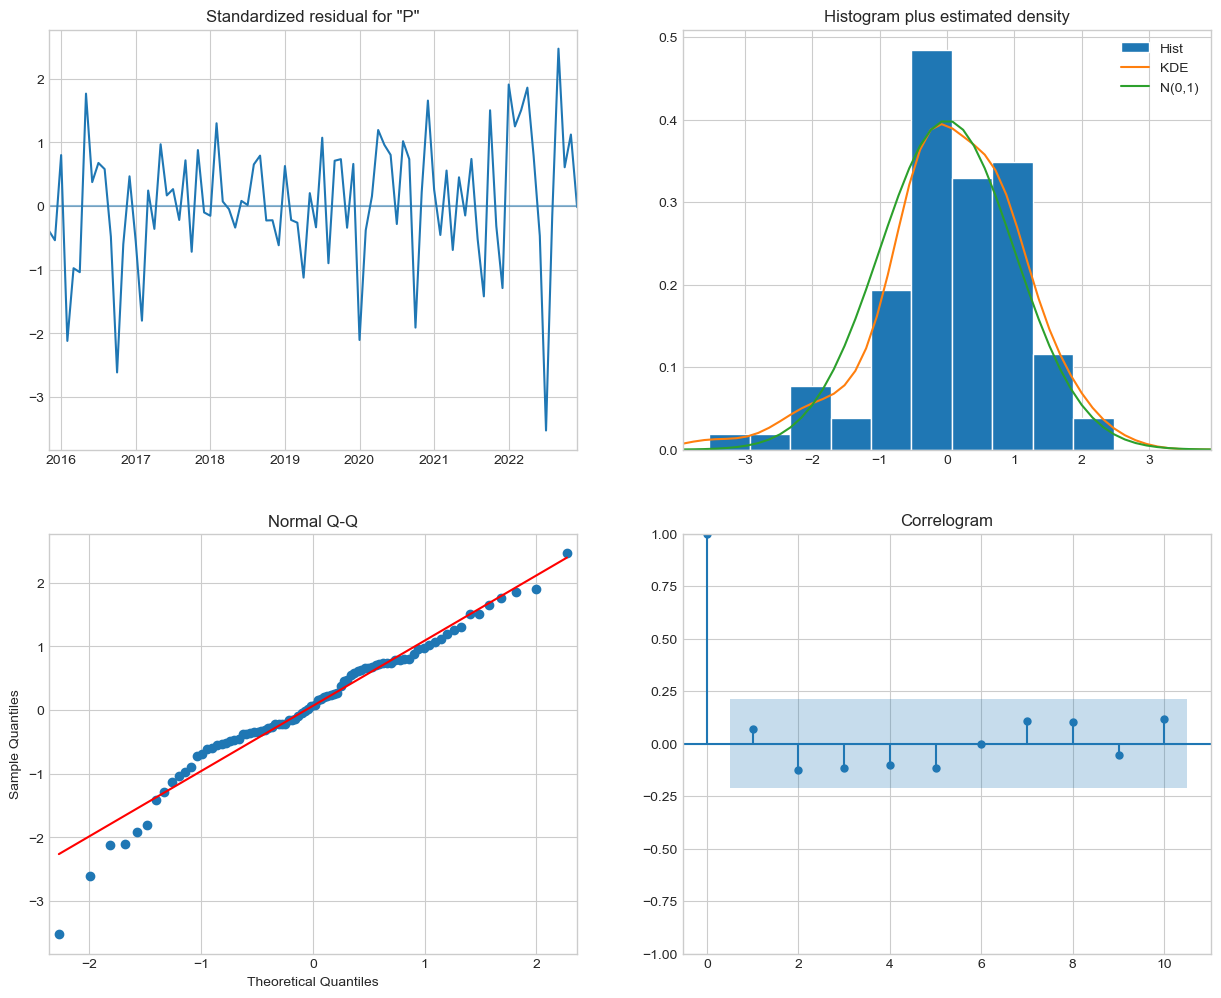

In [925]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [926]:
# Отримання прогнозу за замовчуванням для усіх доступних даних та виведення перших 10 значень прогнозу
predict = results.get_prediction()
predicted_values = predict.predicted_mean
predicted_values[:10]

2014-10-01        0.000000
2014-11-01    11529.508955
2014-12-01    12127.634581
2015-01-01    12928.587466
2015-02-01    13423.758102
2015-03-01    16154.650087
2015-04-01    17154.100735
2015-05-01    18660.723420
2015-06-01    17117.480429
2015-07-01    16796.445941
Freq: MS, Name: predicted_mean, dtype: float64

In [927]:
# Отримання прогнозу для навчальної вибірки з початку 2015 року
predict = results.get_prediction(start='2014-10-01')
metrics(train_econom['2014-10-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -13.317
	P-значення = 0.000
Критичне значення :
	1%: -3.4989097606014496 - Дані  стаціонарні з ймовірністю 99% відсотків
	5%: -2.891516256916761 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.5827604414827157 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 864.2429
MSE: 2494966.158
MAPE: 0.0501
MPE: 0.0097
Стандартна похибка: 1579.5462


In [928]:
# Отримання прогнозу з січня 2023 року по грудень 2025 року
predict = results.get_prediction(start='2023', end='2026')

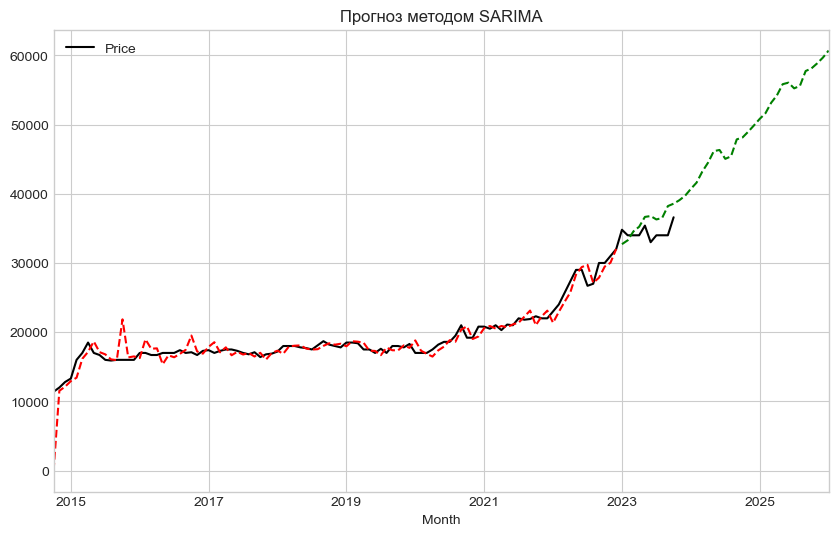

In [929]:
ax = data_econom.plot(figsize=(10,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [930]:
# Отримання прогнозу з січня 2023 року по жовтень 2023 року
predict = results.get_prediction(start='2023-01-01', end='2023-10-01')

# Розрахунок метрик якості прогнозу для порівняння зі змінними test_econom
metrics(test_econom, predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -3.582
	P-значення = 0.006
Критичне значення :
	1%: -4.9386902332361515 - Дані не стаціонарні з ймовірністю 99% відсотків
	5%: -3.477582857142857 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.8438679591836733 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 2061.621
MSE: 5574064.6076
MAPE: 0.0603
MPE: -0.044
Стандартна похибка: 2360.9457


In [931]:
# Отримання прогнозу
predict = results.get_prediction(start='2023', end='2026')

# Отримання середніх значень прогнозу
predicted_mean = predict.predicted_mean

# Виведення середніх значень прогнозу
print(predicted_mean)

2023-01-01    32714.922429
2023-02-01    33273.028558
2023-03-01    34556.473214
2023-04-01    35236.721022
2023-05-01    36654.890691
2023-06-01    36780.393154
2023-07-01    36287.886835
2023-08-01    36502.012608
2023-09-01    38218.257182
2023-10-01    38567.526069
2023-11-01    39066.978668
2023-12-01    39710.043546
2024-01-01    40701.042389
2024-02-01    41608.121018
2024-03-01    43206.604894
2024-04-01    44496.827534
2024-05-01    46154.064349
2024-06-01    46328.618835
2024-07-01    45045.744895
2024-08-01    45405.798848
2024-09-01    47859.028108
2024-10-01    48130.620946
2024-11-01    48970.879127
2024-12-01    49880.014975
2025-01-01    50819.435577
2025-02-01    51635.568034
2025-03-01    53156.907719
2025-04-01    54220.581161
2025-05-01    55832.637634
2025-06-01    56053.652113
2025-07-01    55231.480781
2025-08-01    55584.737215
2025-09-01    57735.211978
2025-10-01    58106.278053
2025-11-01    58835.931841
2025-12-01    59669.405786
2026-01-01    60688.821453
F

In [953]:
"""У 2023 році спостерігається зростання середньомісячної ціни, починаючи з 32,714.92 і закінчуючи 38,567.53 в грудні 2023 року.
В 2024 році прогнозується подальше зростання цін, протягом цього року середньомісячна ціна зросте з 39,710.04 в січні до 50,819.44 в жовтні.
У 2025 році також передбачається зростання цін, і середньомісячна ціна збільшиться з 51,635.57 в січні до 59,669.41 в грудні.
В 2026 році прогнозується подальше зростання цін, протягом року середньомісячна ціна зросте з 60,688.82 в січні до нового рівня.
"""

'У 2023 році спостерігається зростання середньомісячної ціни, починаючи з 32,714.92 і закінчуючи 38,567.53 в грудні 2023 року.\nВ 2024 році прогнозується подальше зростання цін, протягом цього року середньомісячна ціна зросте з 39,710.04 в січні до 50,819.44 в жовтні.\nУ 2025 році також передбачається зростання цін, і середньомісячна ціна збільшиться з 51,635.57 в січні до 59,669.41 в грудні.\nВ 2026 році прогнозується подальше зростання цін, протягом року середньомісячна ціна зросте з 60,688.82 в січні до нового рівня.\n'

In [932]:
# Робимо прогноз для нерухомості Comfort
train_comfort=data_comfort['2014':'2022']
train_comfort.head()

,Price
Month,
2014-10-01,12200.0
2014-11-01,12800.0
2014-12-01,14000.0
2015-01-01,14300.0
2015-02-01,20200.0


In [933]:
test_comfort = data_comfort['2023']
test_comfort.head()

,Price
Month,
2023-01-01,38100.0
2023-02-01,38000.0
2023-03-01,40000.0
2023-04-01,40000.0
2023-05-01,38200.0


In [934]:
mod = sm.tsa.statespace.SARIMAX(train_comfort, order=(1, 0, 0), seasonal_order=(1, 1, 0, 12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9006      0.016     56.510      0.000       0.869       0.932
ar.S.L12      -0.4348      0.050     -8.625      0.000      -0.534      -0.336
sigma2      2.192e+06   2.48e+05      8.840      0.000    1.71e+06    2.68e+06


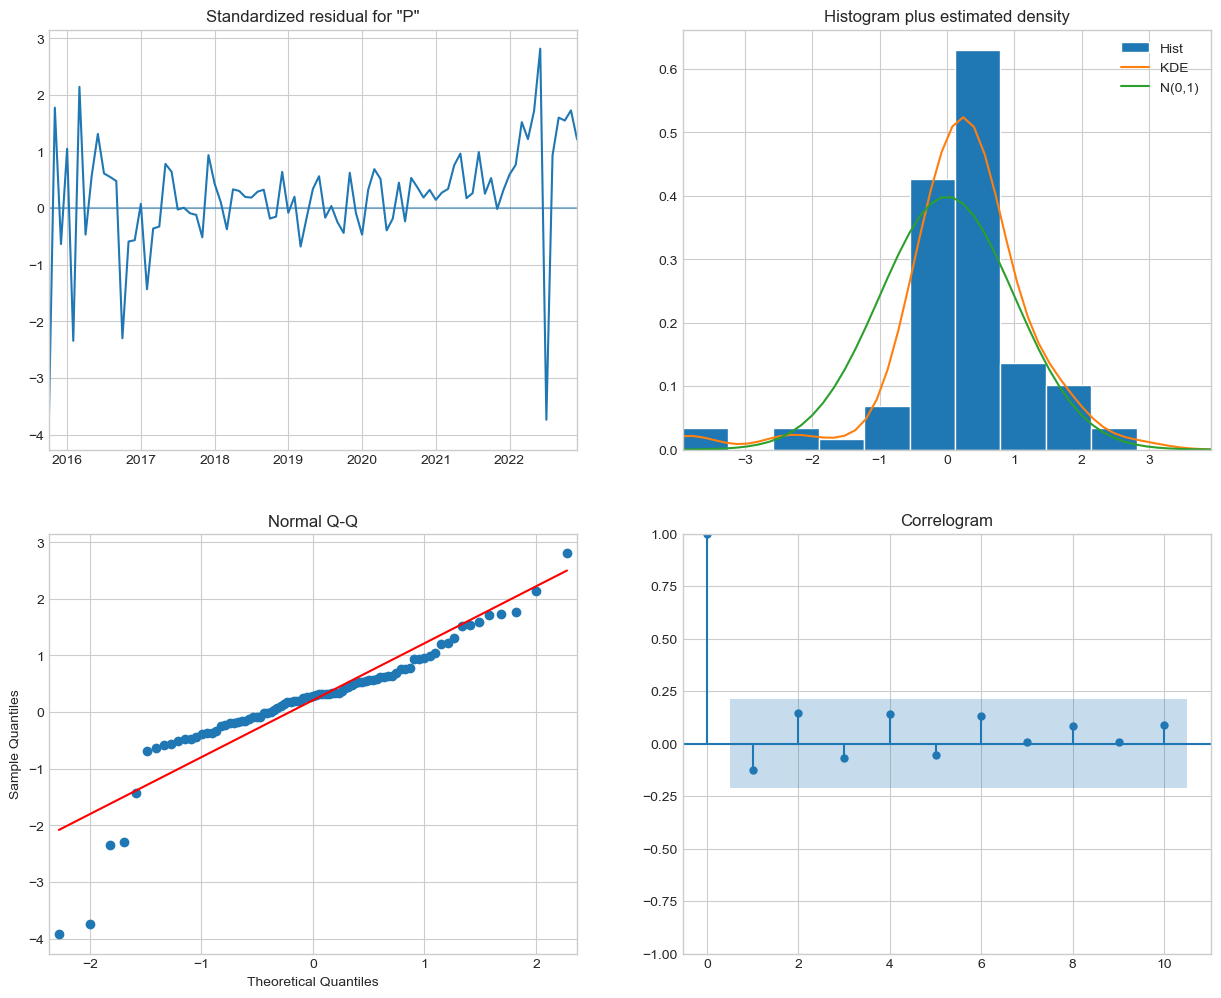

In [935]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [936]:
predict = results.get_prediction()
predicted_values = predict.predicted_mean
predicted_values[:10]

2014-10-01        0.000000
2014-11-01     9752.329264
2014-12-01    10508.604719
2015-01-01    11423.243950
2015-02-01    11758.078267
2015-03-01    15800.765481
2015-04-01    15999.713885
2015-05-01    16954.393469
2015-06-01    15863.270622
2015-07-01    13926.338147
Freq: MS, Name: predicted_mean, dtype: float64

In [937]:
predict = results.get_prediction(start='2014-10-01')
metrics(train_econom['2014-10-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -4.377
	P-значення = 0.000
Критичне значення :
	1%: -3.5078527246648834 - Дані  стаціонарні з ймовірністю 99% відсотків
	5%: -2.895382030636155 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.584823877658872 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 2658.8834
MSE: 10125947.9234
MAPE: 0.1442
MPE: -0.0919
Стандартна похибка: 3182.1295


In [938]:
predict = results.get_prediction(start='2023', end='2026')

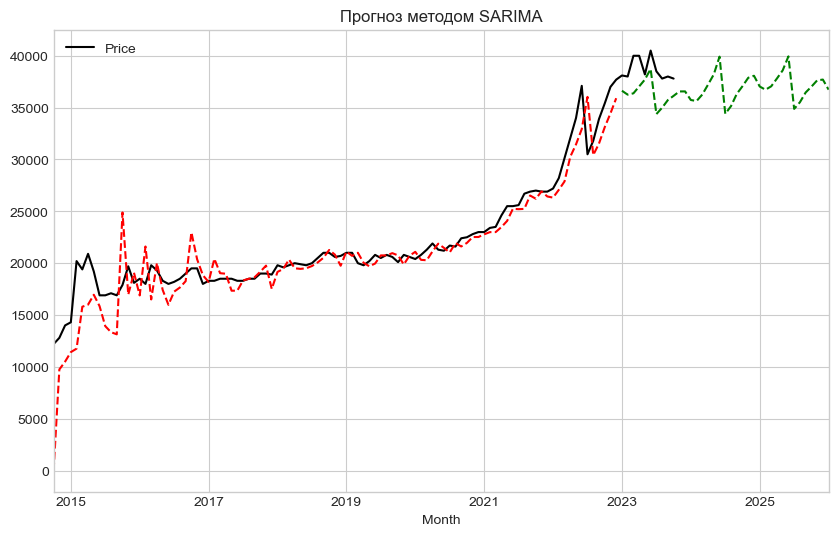

In [939]:
ax = data_comfort.plot(figsize=(10,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [940]:
predict = results.get_prediction(start='2023-01-01', end='2023-10-01')
metrics(test_comfort, predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -6.451
	P-значення = 0.000
Критичне значення :
	1%: -5.354256481481482 - Дані  стаціонарні з ймовірністю 99% відсотків
	5%: -3.6462381481481483 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.901197777777778 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 2293.6062
MSE: 6331268.1429
MAPE: 0.0591
MPE: 0.0591
Стандартна похибка: 2516.2011


In [941]:
predict = results.get_prediction(start='2023', end='2026')
predicted_mean = predict.predicted_mean
print(predicted_mean)

2023-01-01    36627.972378
2023-02-01    36248.878730
2023-03-01    36378.001020
2023-04-01    37041.971222
2023-05-01    37709.111982
2023-06-01    38725.548229
2023-07-01    34375.919868
2023-08-01    34992.161461
2023-09-01    35728.579187
2023-10-01    36135.793672
2023-11-01    36560.675404
2023-12-01    36563.657072
2024-01-01    35734.501141
2024-02-01    35636.491427
2024-03-01    36263.178061
2024-04-01    37220.676045
2024-05-01    38205.637720
2024-06-01    39918.391159
2024-07-01    34401.601419
2024-08-01    35145.132817
2024-09-01    36321.304118
2024-10-01    37065.748186
2024-11-01    37877.357079
2024-12-01    38071.538018
2025-01-01    37036.050950
2025-02-01    36725.105563
2025-03-01    37053.750265
2025-04-01    37810.036083
2025-05-01    38590.535783
2025-06-01    39940.850944
2025-07-01    34877.754783
2025-08-01    35517.522197
2025-09-01    36458.888204
2025-10-01    37017.435383
2025-11-01    37625.529523
2025-12-01    37704.721885
2026-01-01    36730.249532
F

In [954]:
"""
З січня 2023 року по грудень 2023 року спостерігалося значне зменшення середньомісячної ціни, зі значенням 36,627.97 в січні до 36,563.66 в грудні 2023 року.
У 2024 році ціни почали зростати, зі значенням 35,734.50 в січні, до 38,071.54 в грудні 2024 року.
У 2025 році також спостерігалося збільшення середньомісячної ціни, з 37,036.05 в січні до 37,730.25 в березні, та подальше збільшення до 36,730.25 в січні 2026 року.
"""

'\nЗ січня 2023 року по грудень 2023 року спостерігалося значне зменшення середньомісячної ціни, зі значенням 36,627.97 в січні до 36,563.66 в грудні 2023 року.\nУ 2024 році ціни почали зростати, зі значенням 35,734.50 в січні, до 38,071.54 в грудні 2024 року.\nУ 2025 році також спостерігалося збільшення середньомісячної ціни, з 37,036.05 в січні до 37,730.25 в березні, та подальше збільшення до 36,730.25 в січні 2026 року.\n'

In [942]:
# Робимо прогноз для нерухомості Business
train_business=data_business['2014':'2022']
train_business.head()

,Price
Month,
2014-10-01,16900.0
2014-11-01,18100.0
2014-12-01,20000.0
2015-01-01,21000.0
2015-02-01,25000.0


In [943]:
test_business = data_business['2023']
test_business.head()

,Price
Month,
2023-01-01,72400.0
2023-02-01,75600.0
2023-03-01,73600.0
2023-04-01,65600.0
2023-05-01,65200.0


In [944]:
mod = sm.tsa.statespace.SARIMAX(train_business, order=(1, 0, 1), seasonal_order=(1, 1, 0, 12))
results = mod.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9387      0.010     95.071      0.000       0.919       0.958
ma.L1          0.1922      0.071      2.700      0.007       0.053       0.332
ar.S.L12      -0.5023      0.036    -14.031      0.000      -0.572      -0.432
sigma2      3.414e+06   6.49e-09   5.26e+14      0.000    3.41e+06    3.41e+06


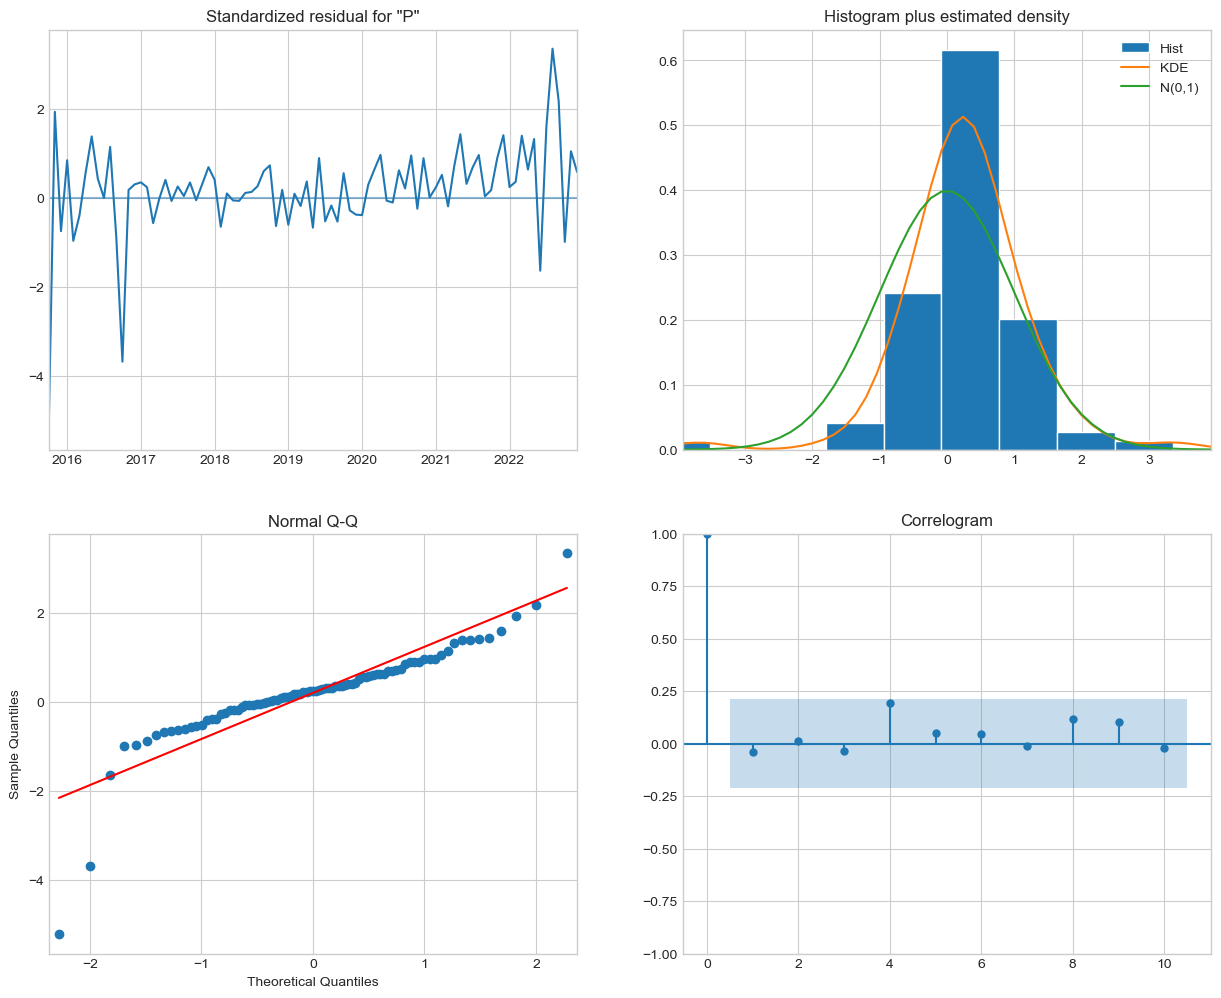

In [945]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [946]:
predict = results.get_prediction()
predicted_values = predict.predicted_mean
predicted_values[:10]

2014-10-01        0.000000
2014-11-01    15176.978045
2014-12-01    16238.389322
2015-01-01    17930.614946
2015-02-01    18789.207142
2015-03-01    22377.552836
2015-04-01    25598.818610
2015-05-01    25501.076364
2015-06-01    23898.216278
2015-07-01    23266.420794
Freq: MS, Name: predicted_mean, dtype: float64

In [947]:
predict = results.get_prediction(start='2014-10-01')
metrics(train_business['2014-10-01':], predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -4.408
	P-значення = 0.000
Критичне значення :
	1%: -3.5078527246648834 - Дані  стаціонарні з ймовірністю 99% відсотків
	5%: -2.895382030636155 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.584823877658872 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 1715.6901
MSE: 8488888.5917
MAPE: 0.0569
MPE: 0.0302
Стандартна похибка: 2913.5697


In [948]:
predict = results.get_prediction(start='2023', end='2026')

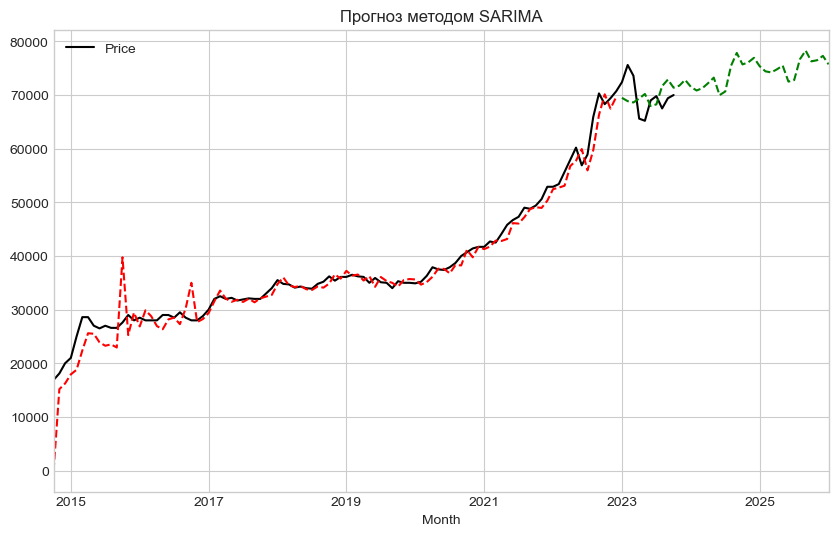

In [949]:
ax = data_business.plot(figsize=(10,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict.predicted_mean.plot(ax=ax, style='--', color='green')
plt.show()

In [950]:
predict = results.get_prediction(start='2023-01-01', end='2023-10-01')
metrics(test_business, predict.predicted_mean)

Тест на стаціонарність:
	T-статистика = -8.208
	P-значення = 0.000
Критичне значення :
	1%: -5.354256481481482 - Дані  стаціонарні з ймовірністю 99% відсотків
	5%: -3.6462381481481483 - Дані  стаціонарні з ймовірністю 95% відсотків
	10%: -2.901197777777778 - Дані  стаціонарні з ймовірністю 90% відсотків
MAD: 3500.4731
MSE: 15272984.6222
MAPE: 0.05
MPE: -0.003
Стандартна похибка: 3908.0666


In [951]:
predict = results.get_prediction(start='2023', end='2026')
predicted_mean = predict.predicted_mean
print(predicted_mean)

2023-01-01    69469.467752
2023-02-01    68859.983336
2023-03-01    68610.448371
2023-04-01    69343.333495
2023-05-01    70199.945244
2023-06-01    67953.132934
2023-07-01    68258.257228
2023-08-01    71665.241571
2023-09-01    72880.894788
2023-10-01    71366.605826
2023-11-01    71746.874490
2023-12-01    72826.405421
2024-01-01    71535.505617
2024-02-01    70846.443699
2024-03-01    71262.953248
2024-04-01    72205.070934
2024-05-01    73243.170083
2024-06-01    69972.874799
2024-07-01    70665.154801
2024-08-01    75441.166915
2024-09-01    77847.287803
2024-10-01    75705.104805
2024-11-01    76086.497357
2024-12-01    76938.470596
2025-01-01    75360.334321
2025-02-01    74413.152223
2025-03-01    74215.296765
2025-04-01    74789.655343
2025-05-01    75490.033604
2025-06-01    72502.377403
2025-07-01    72782.934686
2025-08-01    76667.357821
2025-09-01    78284.080870
2025-10-01    76277.581270
2025-11-01    76489.723862
2025-12-01    77297.652630
2026-01-01    75715.154968
F

In [955]:
"""
З січня 2023 року по грудень 2023 року спостерігалося збільшення середньомісячної ціни, зі значенням 69,469.47 в січні до 72,826.41 в грудні 2023 року.
У 2024 році спостерігається подальше збільшення цін, починаючи з 71,535.51 в січні і досягаючи 76,938.47 в грудні 2024 року.
У 2025 році знову спостерігається збільшення цін, з 75,360.33 в січні до 77,297.65 в грудні 2025 року.
"""

'\nЗ січня 2023 року по грудень 2023 року спостерігалося збільшення середньомісячної ціни, зі значенням 69,469.47 в січні до 72,826.41 в грудні 2023 року.\nУ 2024 році спостерігається подальше збільшення цін, починаючи з 71,535.51 в січні і досягаючи 76,938.47 в грудні 2024 року.\nУ 2025 році знову спостерігається збільшення цін, з 75,360.33 в січні до 77,297.65 в грудні 2025 року.\n'